# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We set seed to better reproduce results later on.
np.random.seed(12345)

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [87]:
# Activation functions
def activate(activations, selected_function = "none"):
    
    if selected_function == "none":
        y = activations
    elif selected_function == "relu" :
        y = np.maximum(0, activations)
    elif selected_function == "sigmoid" :
        y = 1 / (1 + np.exp(-activations))
    return y

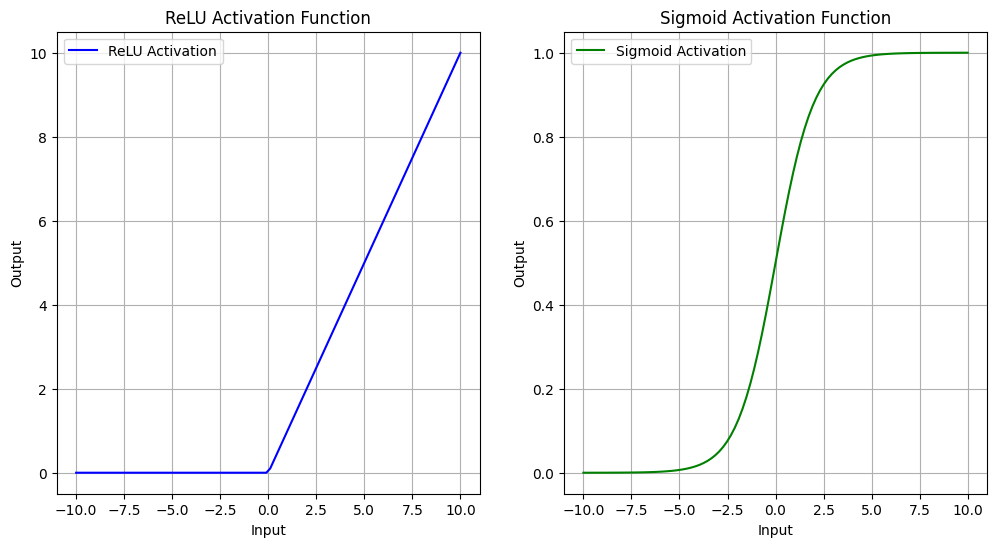

In [88]:
# TODO Test your activation functions, is the returning values what you expect?
x = np.linspace(-10, 10, 100)
y_relu = activate(x, selected_function="relu")
y_sigmoid = activate(x, selected_function="sigmoid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y_relu, label='ReLU Activation', color='blue')
plt.title('ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, y_sigmoid, label='Sigmoid Activation', color='green')
plt.title('Sigmoid Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [89]:
def d_activate(activations, selected_function = "none"):
    if selected_function == "none":
        dy = np.ones_like(activations)
    elif selected_function == "relu":
        dy = np.where(activations > 0, 1, 0)
    elif selected_function == "sigmoid":
        dy = activate(activations, selected_function="sigmoid") * (1 - activate(activations, selected_function="sigmoid"))
    return dy

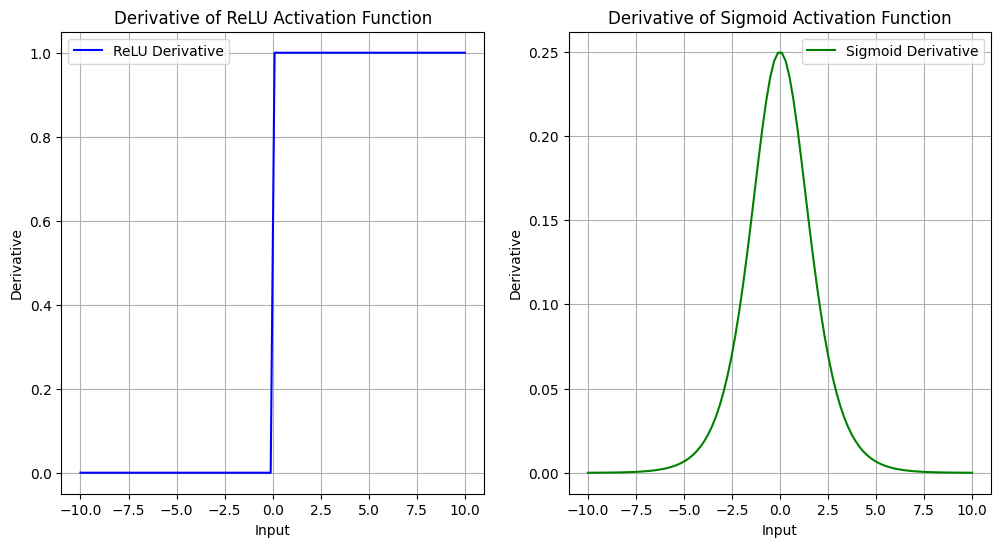

In [90]:
# TODO Test your activation function derivatives, is the returning values what you expect?
x = np.linspace(-10, 10, 100)
dy_relu = d_activate(x, selected_function="relu")
dy_sigmoid = d_activate(x, selected_function="sigmoid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, dy_relu, label='ReLU Derivative', color='blue')
plt.title('Derivative of ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Derivative')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, dy_sigmoid, label='Sigmoid Derivative', color='green')
plt.title('Derivative of Sigmoid Activation Function')
plt.xlabel('Input')
plt.ylabel('Derivative')
plt.grid()
plt.legend()
plt.show()

### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [91]:
# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y):
    loss = np.mean((y_hat - y) ** 2)
    return loss


# TODO: Choose another loss function and implement it
def other_loss(y_hat, y):
    loss = np.mean(np.abs(y_hat - y))  # L1 loss (Mean Absolute Error)
    return loss

The derivatives of the loss is with respect to the predicted value **y_hat**.

In [92]:
def d_MSE_loss(y_hat, y):
    dy = 2 * (y_hat - y) / y.size
    return dy

# TODO: Choose another loss function and implement it
def d_other_loss(y_hat, y):
    dy = np.sign(y_hat - y) / y.size  # Derivative of L1 loss (Mean Absolute Error)
    return dy

### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [93]:
def propagate_forward(weights, activations, bias, activation_function="none"):
    dot_product = np.dot(activations, weights) + bias
    new_activations = activate(dot_product, activation_function)
    return new_activations

### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [94]:
# Calculates the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights and the input signal (activations).

def propagate_backward(weights, activations, dl_dz, bias, activation_function="none"):
    # NOTE: dl_dz is the derivative of the loss based on the previous layers activations/outputs
    dot_product = np.dot(activations, weights) + bias
    d_loss = d_activate(dot_product, activation_function) * dl_dz
    d_weights = np.dot(activations.T, d_loss)
    d_bias = np.sum(d_loss, axis=0, keepdims=True)
    d_activations = np.dot(d_loss, weights.T)
    
    return d_weights, d_bias, d_activations

## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [95]:
class NeuralNet(object):
    
    # Setup all parameters and activation functions.
    # This function runs directly when a new instance of this class is created.
    def __init__(self, input_dim, output_dim, hidden_layers):
        self.weights = []
        self.biases = []
        self.activation_functions = []
        
        # We want to iterate through: Input -> Hidden 1 -> Hidden 2 -> Output
        layer_sizes = [input_dim] + hidden_layers + [output_dim]
        
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i+1]
            
            # Random normal * sqrt(2 / input_size) keeps variance stable
            weight = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
            
            bias = np.zeros((1, n_out)) # Biases typically start at 0
            
            self.weights.append(weight)
            self.biases.append(bias)
            
            # Use 'relu' for hidden layers, 'softmax' or 'sigmoid' for output if needed
            # Assuming your class handles activation strings:
            if i == len(layer_sizes) - 2:
                self.activation_functions.append("none") # or linear/sigmoid for output
            else:
                self.activation_functions.append("relu")
    
    
    # Predict the input throught the network and calculate the output.
    def forward(self, x):

        # TODO: Add support for a bias for each neuron in the code below.
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            x = propagate_forward(layer_weights, x, layer_bias, layer_activation_function)
            
        return x
    
    
    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    # The weight updates are happening "in-place", thus we are only returning the loss from this function.
    # Note that this function can handle a variable size of the input (x), both full datasets or smaller parts of the dataset.
    def adjust_weights(self, x, y, learning_rate=1e-4):
        activation = x
        activation_history = [] # NOTE: We need the previous (or intermediate) activations to make use of the "chain rule" (see lecture notes).
        
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation_history.append(activation)
            activation = propagate_forward(layer_weights, activation, layer_bias, layer_activation_function)
           
        # NOTE: The "activation" variable is changing as we go forward in the neural network.
        loss = MSE_loss(activation,y)
        d_activations = d_MSE_loss(activation,y) # NOTE: The final output can be "seen as" the final activations, thus the name.
        
        for layer_weights, layer_bias, layer_activation_function, previous_activations in reversed(list(zip(self.weights, self.biases, self.activation_functions, activation_history))):
            d_weights, d_bias, d_activations = propagate_backward(layer_weights, previous_activations, d_activations, layer_bias, layer_activation_function)

            # NOTE: Here is where the weight update is happening.
            layer_weights -= learning_rate * d_weights
            layer_bias -= learning_rate * d_bias
                        
        return loss
    
    
    # A function for the training of the network.
    def train_net(self, x, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False):
        loss_history = []
        accuracy_history = []
        
        num_samples = x.shape[0]
        
        # Data Splitting
        if use_validation_data:
            split_index = int(0.8 * num_samples)
            x_train, x_val = x[:split_index], x[split_index:]
            y_train, y_val = y[:split_index], y[split_index:]
            
            x_to_train = x_train
            y_to_train = y_train
            num_samples_train = x_train.shape[0]
            
            best_val_loss = float('inf')
            patience = 5
            patience_counter = 0
        else:
            x_to_train = x
            y_to_train = y
            num_samples_train = num_samples

        # Main Training Loop
        for epoch in range(epochs):
            indices = np.random.permutation(num_samples_train)
            x_shuffled = x_to_train[indices]
            y_shuffled = y_to_train[indices]
            
            epoch_loss = 0
            num_batches = 0
            
            # Mini-Batch Gradient Descent
            for i in range(0, num_samples_train, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # adjust_weights returns the loss for this batch
                current_loss = self.adjust_weights(x_batch, y_batch, learning_rate)
                epoch_loss += current_loss
                num_batches += 1
            
            # Store Average Loss
            avg_loss = epoch_loss / num_batches
            loss_history.append(avg_loss)
            
            # Calculate and store accuracy
            output = self.forward(x_to_train) 
            
            # np.argmax checks which index has the highest probability (e.g., [0.1, 0.9] -> index 1)
            predictions = np.argmax(output, axis=1)
            true_labels = np.argmax(y_to_train, axis=1)
            
            accuracy = np.mean(predictions == true_labels)
            accuracy_history.append(accuracy)

            # Print status
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {accuracy:.4f}")

            # Validation & Early Stopping (Inside the loop)
            if use_validation_data:
                val_output = self.forward(x_val)
                val_loss = MSE_loss(val_output, y_val) # Assuming you have MSE_loss available
                
                # Check for improvement
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                    break

        return loss_history, accuracy_history

## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

Epoch 1/100 | Loss: 177.6987 | Acc: 1.0000
Epoch 11/100 | Loss: 5.1423 | Acc: 1.0000
Epoch 21/100 | Loss: 2.1414 | Acc: 1.0000
Epoch 31/100 | Loss: 1.3602 | Acc: 1.0000
Epoch 41/100 | Loss: 0.9655 | Acc: 1.0000
Epoch 51/100 | Loss: 0.7400 | Acc: 1.0000
Epoch 61/100 | Loss: 0.5847 | Acc: 1.0000
Epoch 71/100 | Loss: 0.4818 | Acc: 1.0000
Epoch 81/100 | Loss: 0.4056 | Acc: 1.0000
Epoch 91/100 | Loss: 0.3494 | Acc: 1.0000
Epoch 100/100 | Loss: 0.3081 | Acc: 1.0000


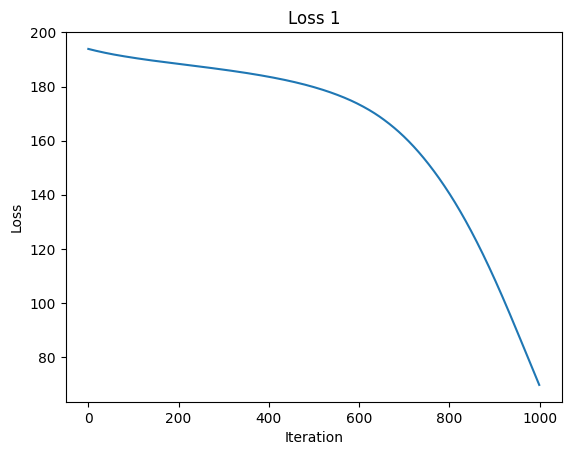

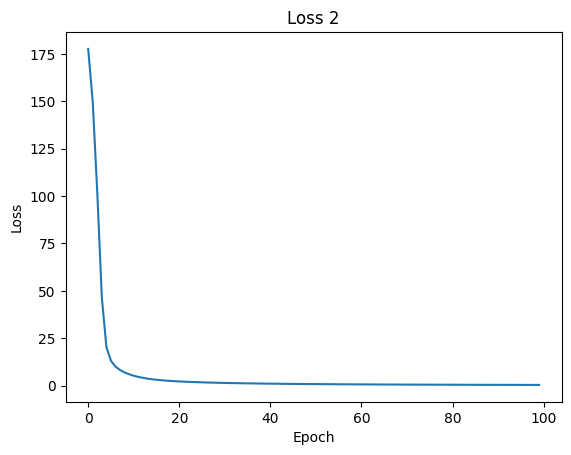

In [96]:
# TODO: You can change most things in this cell if you want to, we encurage it!

n = 5000
d = 10

k = np.random.randint(0,10,(d,1))
x = np.random.normal(0,1,(n,d))
y = np.dot(x,k) + 0.1 + np.random.normal(0,0.01,(n,1))

                        
nn1 = NeuralNet(d, 1, [18, 12])
nn2 = NeuralNet(d, 1, [18, 12])

loss_1 = [nn1.adjust_weights(x, y) for _ in range(1000)] 

loss_2, _ = nn2.train_net(x, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False)

# The difference between using adjust weight and train_net is optimization strategy:
# Batch Gradiant Descent (adjust_weights) vs Mini-Batch Gradient Descent (train_net).
# BGD processes the entire dataset for each weight update. Very stable but computationally expensive
# MGD processes smaller batches which updates much faster and more often. It is more noisy but can escape local minima and often converges faster.

plt.plot(loss_1)
plt.title("Loss 1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.plot(loss_2)
plt.title("Loss 2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

### 8) Dataset 1: Wine - with and without scaling

Read about the Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

Train two neural network, one with scaling and one without. Are we able to see any difference in training results or loss over time?

**Note:** Do not train for to many epochs (more than maybe 50-100). The network might "learn" anyway in the end, but you should still be able to see a difference when training.

===== Run 1 =====
Unscaled Training:
Epoch 1/100 | Loss: 47462460417846971818824279372681485221888.0000 | Acc: 0.4014
Epoch 11/100 | Loss: 5476310046059297500317729476376002560.0000 | Acc: 0.4014
Epoch 21/100 | Loss: 2805362347621876984426500080571252736.0000 | Acc: 0.4014
Epoch 31/100 | Loss: 1437109629524674538939184773226037248.0000 | Acc: 0.4014
Epoch 41/100 | Loss: 736191561501244486173447193882525696.0000 | Acc: 0.4014
Epoch 51/100 | Loss: 377130598870804606770644147916242944.0000 | Acc: 0.4014
Epoch 61/100 | Loss: 193193587161771980669998505364815872.0000 | Acc: 0.4014
Epoch 71/100 | Loss: 98967737521662541559220449690255360.0000 | Acc: 0.4014
Epoch 81/100 | Loss: 50698437841806337601168158482235392.0000 | Acc: 0.4014
Epoch 91/100 | Loss: 25971409107305243178374450724732928.0000 | Acc: 0.4014
Epoch 100/100 | Loss: 14224806109734941170019516295413760.0000 | Acc: 0.4014
Scaled Training
Epoch 1/100 | Loss: 2.0937 | Acc: 0.3944
Epoch 11/100 | Loss: 0.2596 | Acc: 0.6268
Epoch 21/100 

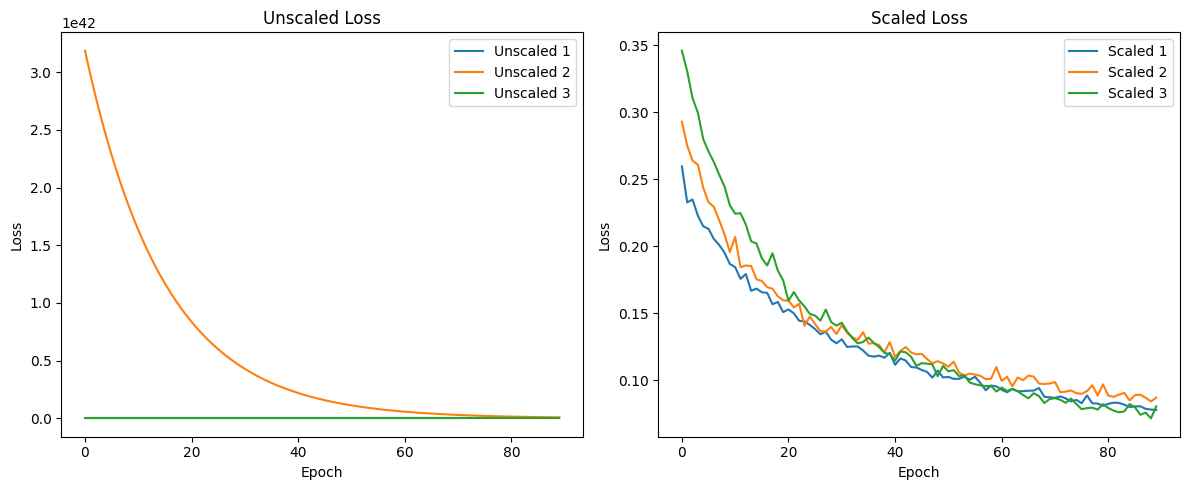

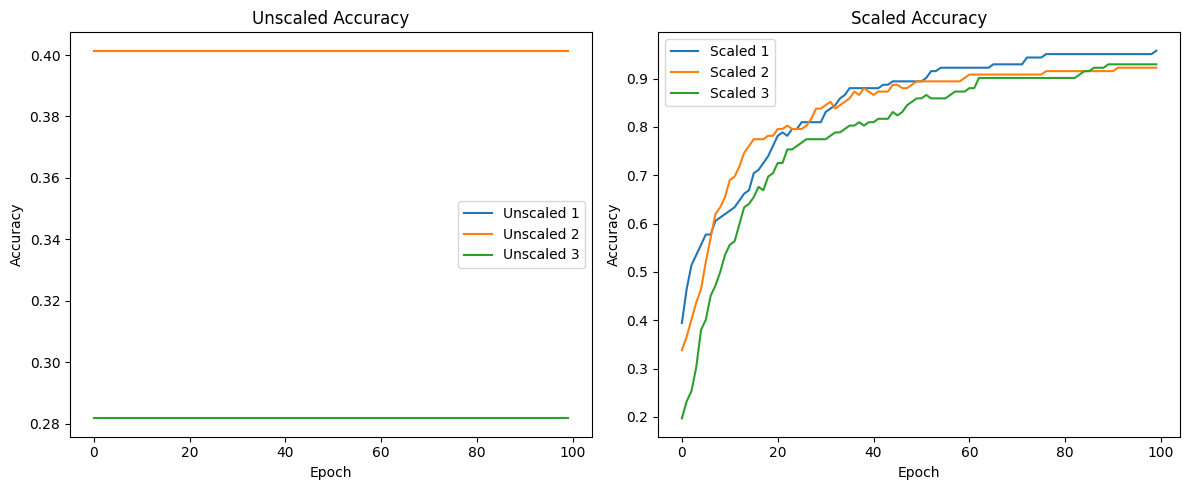

In [97]:
from sklearn import preprocessing # For one-hot-encoding and scaling if needed
from sklearn.model_selection import train_test_split

# Load Data
data_wine = pd.read_csv("wine.csv", header=1).to_numpy()

# Data and Label split
X_unscaled = data_wine[:, :-1]
y_raw = data_wine[:, -1].astype(int)

# One-hot encoding of the labels
# Labels [1, 2, 3] -> [0, 1, 2]
target_encoder = preprocessing.LabelEncoder()
y_raw = target_encoder.fit_transform(y_raw)

num_classes = len(np.unique(y_raw))
y_onehot = np.eye(num_classes)[y_raw]

# Train-test split and scaling
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, y_onehot, test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_unscaled)
x_test_scaled = scaler.transform(x_test_unscaled)

# Network setup
input_dim = x_train_unscaled.shape[1]
losses_unscaled = []
losses_scaled = []
acc_unscaled = []
acc_scaled = []

# Training
for i in range(3):
    nn_wine_unscaled = NeuralNet(input_dim, num_classes, [18, 12])
    nn_wine_scaled = NeuralNet(input_dim, num_classes, [18, 12])
    
    print(f"===== Run {i+1} =====")
    # Train Unscaled
    print("Unscaled Training:")
    loss_u, accuracy_u = nn_wine_unscaled.train_net(x_train_unscaled, y_train, batch_size=32, epochs=100, learning_rate=1e-2)
    loss_u = loss_u[10:] # remove first huge losses to better plot results
    losses_unscaled.append(loss_u)
    acc_unscaled.append(accuracy_u)
    print("Scaled Training")
    # Train Scaled
    loss_s, accuracy_s = nn_wine_scaled.train_net(x_train_scaled, y_train, batch_size=32, epochs=100, learning_rate=1e-2)
    loss_s = loss_s[10:] # remove first huge losses to better plot results
    losses_scaled.append(loss_s)
    acc_scaled.append(accuracy_s)

# Plot the loss
plt.figure(figsize=(12, 5))
# Plot 1: Unscaled
plt.subplot(1, 2, 1)
for i, loss in enumerate(losses_unscaled):
    plt.plot(loss, label=f"Unscaled {i+1}")
plt.title("Unscaled Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot 2: Scaled
plt.subplot(1, 2, 2)
for i, loss in enumerate(losses_scaled):
    plt.plot(loss, label=f"Scaled {i+1}")
plt.title("Scaled Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Plot the accuracy
plt.figure(figsize=(12, 5))
# Plot 1: Unscaled
plt.subplot(1, 2, 1)
for i, acc in enumerate(acc_unscaled):
    plt.plot(acc, label=f"Unscaled {i+1}")
plt.title("Unscaled Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot 2: Scaled
plt.subplot(1, 2, 2)
for i, acc in enumerate(acc_scaled):
    plt.plot(acc, label=f"Scaled {i+1}")
plt.title("Scaled Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Real data and hyper-parameter tuning

Now we are going to use real data, preprocess it, and do hyper-parameter tuning.

Choose two hyper-parameters to tune to try and achive an even better result. **Each chosen parameter needs to have at least 3 different values**. For example, if we were to choose "epochs" then we could test 10, 50, and 100 (optionally more). 

To better see what each hyper-parameter does to the models performance, we recommend doing a *grid-search* on the two chosen parameters. A grid-search tests how the two parameters interact with eachother. There might be a setting in parameter 1 that in combination with a setting in parameter 2 makes the model perform significantly better, compared to the other combinations. A grid-search test all these combinations.

**IMPORTANT NOTE:** Changing the **number of epochs** can be part of the tuning, but it **does not count** towards the two hyper parameters you choose.Choose two hyper-parameters to tune to try and achive an even better result. **Each chosen parameter needs to have at least 3 different values**. For example, if we were to choose "epochs" then we could test 10, 50, and 100 (optionally more). 

To better see what each hyper-parameter does to the models performance, we recommend doing a *grid-search* on the two chosen parameters. A grid-search tests how the two parameters interact with eachother. There might be a setting in parameter 1 that in combination with a setting in parameter 2 makes the model perform significantly better, compared to the other combinations. A grid-search test all these combinations.

**IMPORTANT NOTE:** Changing the **number of epochs** can be part of the tuning, but it **does not count** towards the two hyper parameters you choose.

### 9) Dataset 2: Mushroom

Read about the Mushroom dataset: https://archive.ics.uci.edu/dataset/73/mushroom

Starting Grid Search...
------------------------------
Testing: LR=0.001 | Structure=[24] ...Epoch 1/50 | Loss: 1.2678 | Acc: 0.6492
Epoch 11/50 | Loss: 0.0856 | Acc: 0.9791
Epoch 21/50 | Loss: 0.0434 | Acc: 0.9932
Epoch 31/50 | Loss: 0.0298 | Acc: 0.9954
Epoch 41/50 | Loss: 0.0224 | Acc: 0.9966
Epoch 50/50 | Loss: 0.0186 | Acc: 0.9972
 Done! Accuracy: 0.9972
Testing: LR=0.001 | Structure=[24, 12] ...Epoch 1/50 | Loss: 0.5662 | Acc: 0.6235
Epoch 11/50 | Loss: 0.1172 | Acc: 0.9317
Epoch 21/50 | Loss: 0.0653 | Acc: 0.9652
Epoch 31/50 | Loss: 0.0457 | Acc: 0.9797
Epoch 41/50 | Loss: 0.0352 | Acc: 0.9840
Epoch 50/50 | Loss: 0.0293 | Acc: 0.9877
 Done! Accuracy: 0.9877
Testing: LR=0.001 | Structure=[48, 24, 12] ...Epoch 1/50 | Loss: 0.5696 | Acc: 0.6353
Epoch 11/50 | Loss: 0.0925 | Acc: 0.9575
Epoch 21/50 | Loss: 0.0505 | Acc: 0.9835
Epoch 31/50 | Loss: 0.0339 | Acc: 0.9914
Epoch 41/50 | Loss: 0.0251 | Acc: 0.9958
Epoch 50/50 | Loss: 0.0202 | Acc: 0.9980
 Done! Accuracy: 0.9980
Testing: LR=

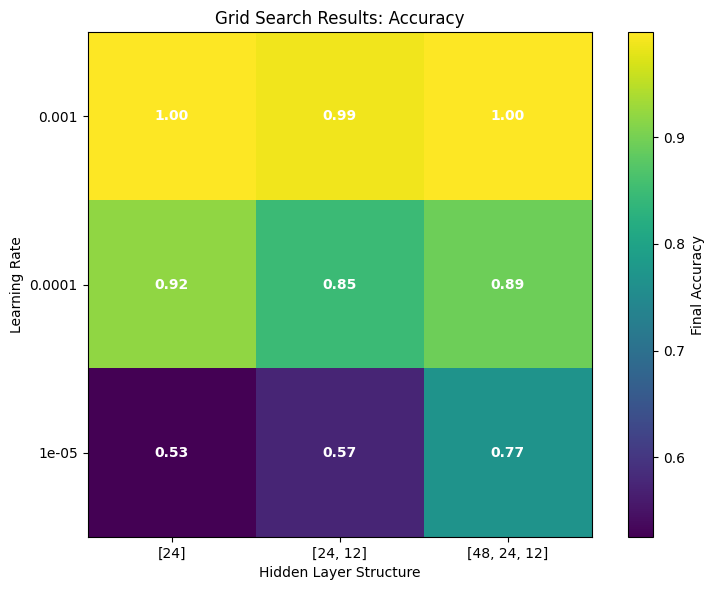

In [98]:
from sklearn import preprocessing # For one-hot-encoding and scaling if needed
from sklearn.model_selection import train_test_split

data_mushroom = pd.read_csv("mushroom.csv", header=0)
# Drop column (feature) 11 because 2500/8000 values missing
data_mushroom = data_mushroom.drop(columns=["stalk-root"])

# Feature label split
y_raw = data_mushroom.iloc[:, 0]
X_raw = data_mushroom.iloc[:, 1:]

# Encode features
X_encoded = pd.get_dummies(X_raw, dtype=float) 
X_final = X_encoded.to_numpy()

# Encode labels
le = preprocessing.LabelEncoder()
y_int = le.fit_transform(y_raw)

# One hot encoding for labes
num_classes = len(np.unique(y_int))
y_onehot = np.eye(num_classes)[y_int]

# Test train split
x_train, x_test, y_train, y_test = train_test_split(
    X_final, y_onehot, test_size=0.2, random_state=42
)

# Scale data
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Neural Network setup
input_dim = x_train.shape[1]
losses_scaled = []

# Grid Search setup
# Parameter 1: Learning Rates
learning_rates = [0.001, 0.0001, 0.00001]

# Parameter 2: Hidden Layer Structures
hidden_structures = [
    [24], 
    [24, 12], 
    [48, 24, 12]
]

# Matrix to store the final accuracy of each combination
# Shape: (3 rows, 3 columns)
results_matrix = np.zeros((len(learning_rates), len(hidden_structures)))

print("Starting Grid Search...")
print("-" * 30)

# Grid search
for i, lr in enumerate(learning_rates):
    for j, structure in enumerate(hidden_structures):
        
        print(f"Testing: LR={lr} | Structure={structure} ...", end="")
        
        nn = NeuralNet(input_dim, num_classes, structure)
        
        _, acc_history = nn.train_net(
            x_train_scaled, 
            y_train, 
            batch_size=32, 
            epochs=50, 
            learning_rate=lr,
            use_validation_data=False
        )
        
        # Store the FINAL accuracy achieved in the matrix
        # (You could also use max(acc_history) if you prefer peak performance)
        final_accuracy = acc_history[-1]
        results_matrix[i, j] = final_accuracy
        
        print(f" Done! Accuracy: {final_accuracy:.4f}")

print("-" * 30)
print("Grid Search Complete.")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
cax = ax.imshow(results_matrix, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
cbar = fig.colorbar(cax)
cbar.set_label('Final Accuracy')

# Set ticks and labels
ax.set_xticks(np.arange(len(hidden_structures)))
ax.set_yticks(np.arange(len(learning_rates)))

# Label the ticks with the actual parameter values
# Convert list representations to strings for the labels
structure_labels = [str(s) for s in hidden_structures]
ax.set_xticklabels(structure_labels)
ax.set_yticklabels(learning_rates)

# Axis Titles
ax.set_xlabel("Hidden Layer Structure")
ax.set_ylabel("Learning Rate")
ax.set_title("Grid Search Results: Accuracy")

# Add text annotations inside each square
for i in range(len(learning_rates)):
    for j in range(len(hidden_structures)):
        text = ax.text(j, i, f"{results_matrix[i, j]:.2f}",
                       ha="center", va="center", color="w", fontweight="bold")

plt.tight_layout()
plt.show()


When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: Learning Rate
* Parameter 2: Hidden Layer Structure

* Neural network sizes:
    [24], 
    [24, 12], 
    [48, 24, 12]

Training Final Model with: LR=0.001, Structure=[24]
Epoch 1/50 | Loss: 1.2469 | Acc: 0.6907
Epoch 11/50 | Loss: 0.0910 | Acc: 0.9835
Epoch 21/50 | Loss: 0.0492 | Acc: 0.9952
Epoch 31/50 | Loss: 0.0345 | Acc: 0.9974
Epoch 41/50 | Loss: 0.0268 | Acc: 0.9986
Epoch 50/50 | Loss: 0.0224 | Acc: 0.9989


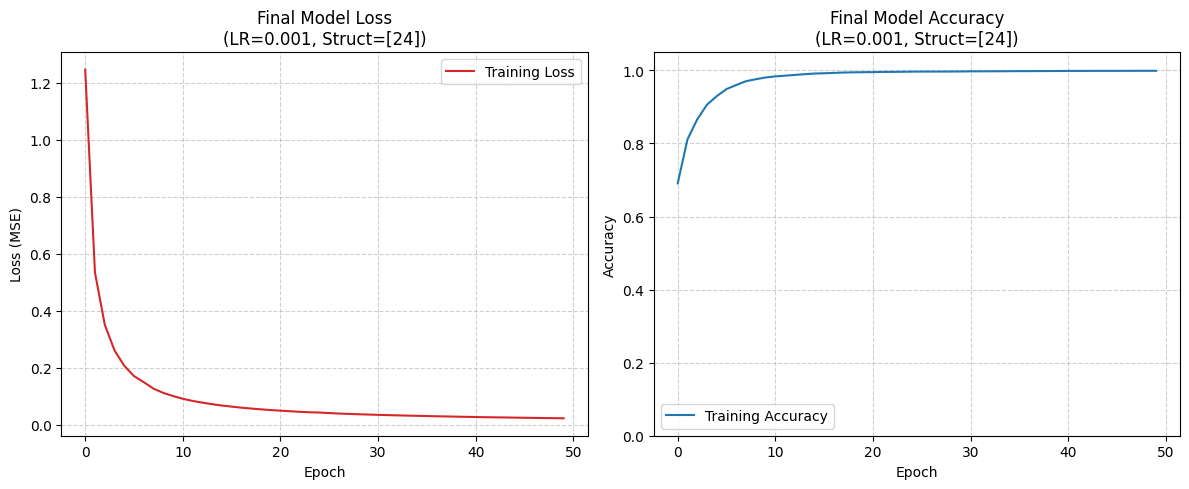

In [101]:
best_learning_rate = 0.001 
best_structure = [24]

print(f"Training Final Model with: LR={best_learning_rate}, Structure={best_structure}")

nn_best = NeuralNet(input_dim, num_classes, best_structure)

best_loss, best_acc = nn_best.train_net(
    x_train_scaled, 
    y_train, 
    batch_size=32, 
    epochs=50, 
    learning_rate=best_learning_rate,
    use_validation_data=False # Or True if you want to use the validation set
)

# Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(best_loss, label="Training Loss", color='tab:red')
plt.title(f"Final Model Loss\n(LR={best_learning_rate}, Struct={best_structure})")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(best_acc, label="Training Accuracy", color='tab:blue')
plt.title(f"Final Model Accuracy\n(LR={best_learning_rate}, Struct={best_structure})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05) # Accuracy is between 0 and 1
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

### 10) Dataset 3: Adult

Read about the Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

**IMPORTANT NOTE:** This dataset is much larger than the previous two (48843 instances). If your code runs slow on your own computer, either run this on the compute-server, or you may exclude parts of this dataset. But you must keep a minimum of 10000 datapoints.

In [100]:
from sklearn import preprocessing # For one-hot-encoding and scaling if needed
from sklearn.model_selection import train_test_split

dataset_3 = pd.read(...) # TODO: Read the data.

# TODO: Preprocess the data.
# NOTE: You can choose how to handle data with missing values. Either remove or "fix" the missing data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

AttributeError: module 'pandas' has no attribute 'read'

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [ ]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why would we want to use different activation functions?

2) Why would we want to use different loss functions?

3) Why are neural networks sensitive to large input values?

4) What is the role of the bias? 

5) What is the purpose of hyper-parameter tuning?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!